# A/B-тестирование

**Задача:**
*Провести оценку результатов A/B-теста*
___

**Цели исследования:**

1) Оценить корректность проведения теста. Для этого:

    1.1) Проверим соответствие данных требованиям ТЗ;
    1.2) Проверить совпадение теста и маркетинговых событий, другие проблемы временных границ теста;
    1.3) Проверить пересечение тестовой аудитории с конкурирующим тестоми и внури групп анализируемого теста;
    
2) Проанализировать результаты теста/
___

**Описание данных:**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

In [ ]:
import pandas as pd
from io import BytesIO
import requests
pd.set_option('display.max_rows', 10)
from datetime import datetime, timedelta
import numpy as np
import plotly.graph_objects as go
import math
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter, FormatStrFormatter,ScalarFormatter
import plotly.express as px
from IPython.display import Markdown
import nbformat
import re
import gdown

import warnings
warnings.filterwarnings("ignore")

## Оглавление

In [ ]:
def generate_table_of_contents(notebook_path):
    notebook_url = 'https://drive.google.com/uc?id=' + notebook_path.split('/')[-2]
    gdown.download(notebook_url, 'notebook.ipynb', quiet=True)

    with open('notebook.ipynb', 'r', encoding='utf-8') as file:
        notebook = nbformat.read(file, nbformat.NO_CONVERT)

    table_of_contents = []
    heading_numbers = [0, 0, 0, 0, 0, 0]  # Начальные значения номеров для разных уровней заголовков

    for cell in notebook['cells']:
        if cell['cell_type'] == 'markdown':
            source = cell['source']
            headers = re.findall(r'^(#+)\s+(.*)$', source, flags=re.MULTILINE)

            for header in headers:
                level = len(header[0])
                title = header[1].strip()

                link = '-'.join(re.findall(r'\w+', title.lower()))
                indentation = '&nbsp;' * 2 * (level - 1)
                line_break = '\n' + '&nbsp;' * 2 * level

                heading_numbers[level - 1] += 1
                heading_number_str = '.'.join(str(num) for num in heading_numbers[:level])

                colab_link = notebook_path + f'#scrollTo={link}'
                table_of_contents.append(f'{line_break}- {heading_number_str} [{title}]({colab_link})')

    markdown_output= '\n'.join(table_of_contents)
    display(Markdown(markdown_output))


# Укажите ссылку на ваш файл на Google Диске
notebook_path = 'https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing'

# Генерирование оглавления
table_of_contents = generate_table_of_contents(notebook_path)
# Отображение оглавления


&nbsp;&nbsp;- 1 [A/B-тестирование](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=a-b-тестирование)

&nbsp;&nbsp;&nbsp;&nbsp;- 1.1 [Оглавление](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=оглавление)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.1 [1) Изучение общей информации:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=1-изучение-общей-информации)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.1.1 [1.1) Рассмотрим 1 датасет - final_ab_events:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=1-1-рассмотрим-1-датасет-final_ab_events)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.1.2 [1.2) Рассмотрим 2 датасет - ab_project_marketing_events:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=1-2-рассмотрим-2-датасет-ab_project_marketing_events)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.1.3 [1.3) Рассмотрим 3 датасет - final_ab_new_users:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=1-3-рассмотрим-3-датасет-final_ab_new_users)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.1.4 [1.4) Рассмотрим 4 датасет - final_ab_participants:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=1-4-рассмотрим-4-датасет-final_ab_participants)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.2 [2) Предобработка данных:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=2-предобработка-данных)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.2.5 [2.1) Рассмотрим 1 датасет - final_ab_events:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=2-1-рассмотрим-1-датасет-final_ab_events)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.2.6 [2.2) Рассмотрим 2 датасет - ab_pme(ab_project_marketing_events):](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=2-2-рассмотрим-2-датасет-ab_pme-ab_project_marketing_events)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.2.7 [2.3) Рассмотрим 3 датасет - final_ab_new_users:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=2-3-рассмотрим-3-датасет-final_ab_new_users)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.2.8 [2.4) Рассмотрим 4 датасет - final_ab_participants:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=2-4-рассмотрим-4-датасет-final_ab_participants)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.3 [3) Оценим корректность проведения теста:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=3-оценим-корректность-проведения-теста)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.3.9 [3.1)  Проверим соответствие данных требованиям ТЗ:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=3-1-проверим-соответствие-данных-требованиям-тз)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.3.10 [3.2) Проверим совпадение теста и маркетинговых событий:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=3-2-проверим-совпадение-теста-и-маркетинговых-событий)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.3.11 [3.3) Проверить пересечение тестовой аудитории с конкурирующим тестоми и внури групп анализируемого теста:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=3-3-проверить-пересечение-тестовой-аудитории-с-конкурирующим-тестоми-и-внури-групп-анализируемого-теста)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.4 [4) Исследовательский анализ данных:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=4-исследовательский-анализ-данных)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.4.12 [4.1) Выясним одинаково ли  распределены в группах количество событий на пользователя:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=4-1-выясним-одинаково-ли-распределены-в-группах-количество-событий-на-пользователя)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.4.13 [4.2) Проанализируем как число событий в выборках распределено по дням:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=4-2-проанализируем-как-число-событий-в-выборках-распределено-по-дням)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.4.14 [Рассмотрим как меняется конверсия в воронке в выборках на разных этапах:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=рассмотрим-как-меняется-конверсия-в-воронке-в-выборках-на-разных-этапах)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.5 [5) Оценим результаты A/B-тестирования:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=5-оценим-результаты-a-b-тестирования)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.6 [ВЫВОД:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=вывод)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1.1.6.15 [Общий вывод:](https://drive.google.com/file/d/1HJ9kV5bmikLUiTci37wtyy5TraInnHmF/view?usp=sharing#scrollTo=общий-вывод)

### 1) Изучение общей информации:



1.   final_ab_events - https://docs.google.com/spreadsheets/d/1zIEPRwX0jxZDZURc1c0Q6NOqfkoR3U8SneyxftXMplc/edit?usp=share_link
2.   ab_project_marketing_events - https://docs.google.com/spreadsheets/d/1w56Q48BS6gJQRFOpgWbIvLi2xOzmP_l5vYmC9NFB87A/edit?usp=share_link
3.   final_ab_new_users - https://docs.google.com/spreadsheets/d/1uRHEw9VzDc_YSV6k6yZkOMuMUY-MnqGVpFARz7yG3SY/edit?usp=sharing
4.   final_ab_participants - https://docs.google.com/spreadsheets/d/1acQlmiUTU4ZNz74lcbBTlgy-TrmtPT_hj8WtlWkIE7k/edit?usp=sharing


In [ ]:
def get_data(link):
  spreadsheet_id = link
  file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
  r = requests.get(file_name)
  data = pd.read_csv(BytesIO(r.content))
  return data


In [ ]:
def table_name(name):
    name_length=len(name)
    print('_'*name_length)
    print(name+':')
    print('- '*int((name_length/2)))

In [ ]:
final_ab_events=get_data('1zIEPRwX0jxZDZURc1c0Q6NOqfkoR3U8SneyxftXMplc')
final_ab_events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 9:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 4:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 9:53:39,login,NaN


In [ ]:
ab_project_marketing_events=get_data('1w56Q48BS6gJQRFOpgWbIvLi2xOzmP_l5vYmC9NFB87A')
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
...,...,...,...,...
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12


In [ ]:
final_ab_new_users=get_data('1uRHEw9VzDc_YSV6k6yZkOMuMUY-MnqGVpFARz7yG3SY')
final_ab_new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [ ]:
final_ab_participants=get_data('1acQlmiUTU4ZNz74lcbBTlgy-TrmtPT_hj8WtlWkIE7k')
final_ab_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


___
#### 1.1) Рассмотрим 1 датасет - final_ab_events:

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

In [ ]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 9:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 4:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [ ]:
print('Количество строк в final_ab_events -',final_ab_events.shape[0])

Количество строк в final_ab_events - 440317


Рассмотри общую информацию

In [ ]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [ ]:
pd.DataFrame({'dtype':final_ab_events.dtypes})

,dtype
user_id,object
event_dt,object
event_name,object
details,float64


___
#### 1.2) Рассмотрим 2 датасет - ab_project_marketing_events:

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

Слишком длинное название датасета ab_project_marketing_events- пусть будет ab_pme

In [ ]:
ab_pme=ab_project_marketing_events

In [ ]:
ab_pme

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
...,...,...,...,...
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12


In [ ]:
print('Количество строк в ab_pme -',ab_pme.shape[0])

Количество строк в ab_pme - 14


Рассмотри общую информацию

In [ ]:
ab_pme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [ ]:
pd.DataFrame({'dtype':ab_pme.dtypes})

,dtype
name,object
regions,object
start_dt,object
finish_dt,object


___
#### 1.3) Рассмотрим 3 датасет - final_ab_new_users:

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [ ]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [ ]:
print('Количество строк в final_ab_new_users -',final_ab_new_users.shape[0])

Количество строк в final_ab_new_users - 61733


Рассмотри общую информацию

In [ ]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [ ]:
pd.DataFrame({'dtype':final_ab_new_users.dtypes})

,dtype
user_id,object
first_date,object
region,object
device,object


___
#### 1.4) Рассмотрим 4 датасет - final_ab_participants:

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [ ]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [ ]:
print('Количество строк в final_ab_participants -',final_ab_participants.shape[0])

Количество строк в final_ab_participants - 18268


Рассмотри общую информацию

In [ ]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [ ]:
pd.DataFrame({'dtype':final_ab_participants.dtypes})

,dtype
user_id,object
group,object
ab_test,object


**ВЫВОД:**

**Вывели 4 датасета и рассмотрели общую информацию.**

___
### 2) Предобработка данных:

#### 2.1) Рассмотрим 1 датасет - final_ab_events:

In [ ]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 9:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 4:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Еще раз выведем таблицу типов final_ab_events:

In [ ]:
pd.DataFrame({'dtype':final_ab_events.dtypes})

,dtype
user_id,object
event_dt,object
event_name,object
details,float64


**Вывод:** так как колонка event_dt показывает дату и время события, стоит изменить тип данных в ней с object на datetime

In [ ]:
final_ab_events['event_dt']=pd.to_datetime(final_ab_events['event_dt'])
pd.DataFrame({'dtype':final_ab_events.dtypes}).loc['event_dt',]

dtype    datetime64[ns]
Name: event_dt, dtype: object

Узнал что у  `read_csv` есть параметр, который позволяет даты сразу в нужный формат переводить </div>

**Вывод:** новый тип данных - *datetime64[ns]*

___
Исследуем пропуски в данных:

In [ ]:
na_count_final_ab_events=pd.DataFrame(final_ab_events.isna().sum())
na_count_final_ab_events.columns=['na_count']
na_count_final_ab_events['%']=round(na_count_final_ab_events['na_count']/final_ab_events.shape[0]*100,2)
na_count_final_ab_events

,na_count,%
user_id,0,0.00
event_dt,0,0.00
event_name,0,0.00
details,377577,85.75


**Вывод:** Очень много пропусков в колонке details, в которой отображается информация о дополнительных данных о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

In [ ]:
event_count_final_ab_events=final_ab_events.pivot_table(index='event_name',values='user_id',aggfunc='count')
event_count_final_ab_events['%']=round(event_count_final_ab_events['user_id']/final_ab_events.shape[0]*100,2)
event_count_final_ab_events

,user_id,%
event_name,,
login,189552,43.05
product_cart,62462,14.19
product_page,125563,28.52
purchase,62740,14.25


In [ ]:
print('Сложим проценты занимаемых покупок событий и пропусков:   ',na_count_final_ab_events.loc['details','%'],'%  +',
     event_count_final_ab_events.loc['purchase','%'],'%   =',
      na_count_final_ab_events.loc['details','%']+event_count_final_ab_events.loc['purchase','%'],'%',)

Сложим проценты занимаемых покупок событий и пропусков:    85.75 %  + 14.25 %   = 100.0 %


**Вывод:** значит все данные которые заполнены в колонке details заполнены ценой собыия purchase - покупка.

In [ ]:
print(na_count_final_ab_events.loc['details','%'],'% от всех пропусков занимают все',
      round(event_count_final_ab_events.drop(index='purchase')['%'].sum(),2),'% строк от 3 остальных типов ивентов.')

85.75 % от всех пропусков занимают все 85.76 % строк от 3 остальных типов ивентов.


**Вывод:** все остальные события занимают все пропуски в колнке details. Пропуски можно оставить.

In [ ]:
final_ab_events.duplicated().sum()

0

**Вывод:** дубликатов не обнаружено

___

#### 2.2) Рассмотрим 2 датасет - ab_pme(ab_project_marketing_events):

In [ ]:
pd.set_option('display.max_rows', 14)
display(ab_pme.head(14))
pd.set_option('display.max_rows', 10)


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Еще раз выведем таблицу типов final_ab_events:

In [ ]:
pd.DataFrame({'dtype':ab_pme.dtypes})

,dtype
name,object
regions,object
start_dt,object
finish_dt,object


**Вывод:** так как колонки start_dt и finish_dt показывают дату, стоит изменить тип данных в ней с object на datetime

In [ ]:
ab_pme['start_dt']=pd.to_datetime(ab_pme['start_dt'])
ab_pme['finish_dt']=pd.to_datetime(ab_pme['finish_dt'])
pd.DataFrame({'dtype':ab_pme.dtypes})

,dtype
name,object
regions,object
start_dt,datetime64[ns]
finish_dt,datetime64[ns]


**Вывод:** новый тип данных - *datetime64[ns]*

___
Исследуем пропуски в данных:

In [ ]:
na_count_ab_pme=pd.DataFrame(ab_pme.isna().sum())
na_count_ab_pme.columns=['na_count']
na_count_ab_pme['%']=round(na_count_ab_pme['na_count']/ab_pme.shape[0]*100,2)
na_count_ab_pme

,na_count,%
name,0,0.0
regions,0,0.0
start_dt,0,0.0
finish_dt,0,0.0


**Вывод:** пропусков нет

In [ ]:
final_ab_events.duplicated().sum()

0

**Вывод:** дубликатов не обнаружено

#### 2.3) Рассмотрим 3 датасет - final_ab_new_users:

In [ ]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Еще раз выведем таблицу типов final_ab_events:

In [ ]:
pd.DataFrame({'dtype':final_ab_new_users.dtypes})

,dtype
user_id,object
first_date,object
region,object
device,object


**Вывод:** так как колонки first_date  показывают дату, стоит изменить тип данных в ней с object на datetime

In [ ]:
final_ab_new_users['first_date']=pd.to_datetime(final_ab_new_users['first_date'])
pd.DataFrame({'dtype':final_ab_new_users.dtypes})

,dtype
user_id,object
first_date,datetime64[ns]
region,object
device,object


**Вывод:** новый тип данных - *datetime64[ns]*

___
Исследуем пропуски в данных:

In [ ]:
na_count_final_ab_new_users=pd.DataFrame(final_ab_new_users.isna().sum())
na_count_final_ab_new_users.columns=['na_count']
na_count_final_ab_new_users['%']=round(na_count_final_ab_new_users['na_count']/na_count_final_ab_new_users.shape[0]*100,2)
na_count_final_ab_new_users

,na_count,%
user_id,0,0.0
first_date,0,0.0
region,0,0.0
device,0,0.0


**Вывод:** пропусков нет

In [ ]:
final_ab_new_users.duplicated().sum()

0

**Вывод:** дубликатов не обнаружено

___

#### 2.4) Рассмотрим 4 датасет - final_ab_participants:

In [ ]:
final_ab_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


Еще раз выведем таблицу типов final_ab_events:

In [ ]:
pd.DataFrame({'dtype':final_ab_participants.dtypes})

,dtype
user_id,object
group,object
ab_test,object


**Вывод:** тут не нужно менять тип данных

___
Исследуем пропуски в данных:

In [ ]:
na_count_final_ab_participants=pd.DataFrame(final_ab_participants.isna().sum())
na_count_final_ab_participants.columns=['na_count']
na_count_final_ab_participants['%']=round(na_count_final_ab_participants['na_count']/na_count_final_ab_participants.shape[0]*100,2)
na_count_final_ab_participants

,na_count,%
user_id,0,0.0
group,0,0.0
ab_test,0,0.0


**Вывод:** пропусков нет.

In [ ]:
final_ab_participants.duplicated().sum()

0

**Вывод:** дубликатов не обнаружено

___

**ВЫВОД:**

**Перевели все даты и время к нужному формату. Иссоедовали пропуски и дубликаты. Столбец details в таблицу final_ab_events нужен для указания стоимости покупки, для остальных же значений там пропуски.**

### 3) Оценим корректность проведения теста:

#### 3.1)  Проверим соответствие данных требованиям ТЗ:

*Отфлильтруем таблицу final_ab_participants, где оставим только нужным нам тест- recommender_system_test. Выведем в отдельную переменную:*

In [ ]:
rstest=final_ab_participants[final_ab_participants['ab_test']=='recommender_system_test']
rstest.head(5)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


___

In [ ]:
rstest.pivot_table(index='group',values='user_id',aggfunc='count')

,user_id
group,
A,3824
B,2877


In [ ]:
print('В нужном тесте было',rstest['group'].nunique(),'группы:')
for x in rstest['group'].unique():
    print('-',x)

В нужном тесте было 2 группы:
- A
- B


**Вывод:**
это соотносится с пункотом ТЗ:

*группы: А — контрольная, B — новая платёжная воронка;*
___

Рассмотрим максимальную и минимальную **даты регистрации** в таблце final_ab_new_users с профилями пользователей:

print('Минимальная дата регистрации:',final_ab_new_users['first_date'].dt.date.min())
print('Максимальная дата регистрации:',final_ab_new_users['first_date'].dt.date.max())

Рассмотрим максимальную и минимальную **дату и время регистрации** в таблце final_ab_events с событиями пользователей:

In [ ]:
print('Максимальная дата и время события:',final_ab_events['event_dt'].min())
print('Минимальная дата и время события:',final_ab_events['event_dt'].max())

Максимальная дата и время события: 2020-12-07 00:00:33
Минимальная дата и время события: 2020-12-30 23:36:33


___

**Согласно ТЗ дата остановки набора новых пользователей: 2020-12-21**

Отфильтруем дату регистрации меньше этой даты в таблице final_ab_new_users:

In [ ]:
final_ab_new_users=final_ab_new_users[final_ab_new_users['first_date']<=datetime(2020, 12, 21)]
final_ab_new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [ ]:
print('Максимальная дата регистрации:',final_ab_new_users['first_date'].dt.date.max())

Максимальная дата регистрации: 2020-12-21


___
Согласно ТЗ аудитория: 15% новых пользователей из региона EU.

Проверим:

In [ ]:
users_region_count=final_ab_new_users[final_ab_new_users['first_date']<=datetime(2020, 12, 21)].pivot_table(index='region',values='user_id',aggfunc='count')
users_region_count.loc['sum_y','user_id']=users_region_count['user_id'].sum(axis=0)
users_region_count['%']=round(users_region_count['user_id']/users_region_count.loc['sum_y','user_id']*100,2)

table_name('Доля всех пользователей по регионам:')
users_region_count

____________________________________
Доля всех пользователей по регионам::
- - - - - - - - - - - - - - - - - - 


,user_id,%
region,,
APAC,2883.0,5.11
CIS,2900.0,5.14
EU,42340.0,74.98
N.America,8347.0,14.78
sum_y,56470.0,100.00


In [ ]:
only_ab_final_new_users=final_ab_new_users[final_ab_new_users['user_id'].isin(rstest['user_id'].unique())]
only_ab_final_new_users=only_ab_final_new_users[only_ab_final_new_users['first_date']<=datetime(2020, 12, 21)]

only_ab_final_new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
13,E6DE857AFBDC6102,2020-12-07,EU,PC
20,DD4352CDCF8C3D57,2020-12-07,EU,Android
23,831887FE7F2D6CBA,2020-12-07,EU,Android
39,4CB179C7F847320B,2020-12-07,EU,iPhone
...,...,...,...,...
61685,A09DFE27D4CFF8E8,2020-12-20,EU,Android
61693,0F7D49FC184EDCDE,2020-12-20,EU,PC
61709,574ACBC674BC385D,2020-12-20,EU,Mac
61710,0416B34D35C8C8B8,2020-12-20,EU,Android


In [ ]:
only_ab_users_region_count=only_ab_final_new_users.pivot_table(index='region',values='user_id',aggfunc='count')
only_ab_users_region_count.loc['sum_y','user_id']=only_ab_users_region_count['user_id'].sum(axis=0)
only_ab_users_region_count['%']=round(only_ab_users_region_count['user_id']/only_ab_users_region_count.loc['sum_y','user_id']*100,2)
table_name('Доля пользователей проходивших нужный А/Б-тест по регионам:')

only_ab_users_region_count

___________________________________________________________
Доля пользователей проходивших нужный А/Б-тест по регионам::
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,user_id,%
region,,
APAC,72.0,1.07
CIS,55.0,0.82
EU,6351.0,94.78
N.America,223.0,3.33
sum_y,6701.0,100.00


In [ ]:
print('Доля пользователей из EU, проходивших наш А/Б-тест, относительно всех пользователй из EU -',
      round(only_ab_users_region_count.loc['EU','user_id']/users_region_count.loc['EU','user_id']*100,2),'%.')

Доля пользователей из EU, проходивших наш А/Б-тест, относительно всех пользователй из EU - 15.0 %.


**Вывод:**

**Условия ТЗ, которое гласит что 15% новых пользователей из региона EU - выполняется.**
___

In [ ]:
print('Фактическое количество участников теста recommender_system_test -',rstest.shape[0])
print('Ожидаемое количество участников теста: 6000')
print('Асболютная разница =  +',rstest.shape[0]-6000, 'в пользу фактического количества.')
print('Относительная разница =  +',round((rstest.shape[0]/6000-1)*100,2), '%    в пользу фактического количества.')

Фактическое количество участников теста recommender_system_test - 6701
Ожидаемое количество участников теста: 6000
Асболютная разница =  + 701 в пользу фактического количества.
Относительная разница =  + 11.68 %    в пользу фактического количества.


**Вывод: Это условие также можно считать выполненным. Так как с увеличением количества тестируемых объектов растет точность теста.**

In [ ]:
rstest

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


In [ ]:
print('Количество пересечений пользователей из группы А и В равно',
      rstest.query('group=="A"')['user_id'].isin(rstest.query('group=="B"')['user_id']).sum())

Количество пересечений пользователей из группы А и В равно 0


___

Объединим дествия пользователй, информацию об их группах и информацию из профлией пользователй в одну таблицу - **data**:

In [ ]:
data=final_ab_events.merge(rstest,how='right').merge(final_ab_new_users)
data=data.drop(columns='ab_test')
data['event_dt']=pd.to_datetime(data['event_dt'].dt.date)
data['days']=data['event_dt']-data['first_date']
data['days']=data['days'].dt.days

data['event_day_of_dec']=data['event_dt'].dt.day

data[['days','event_day_of_dec']]=data[['days','event_day_of_dec']].convert_dtypes()
pd.set_option('display.max_rows', 10)
data

,user_id,event_dt,event_name,details,group,first_date,region,device,days,event_day_of_dec
0,D1ABA3E2887B6A73,2020-12-07,purchase,99.99,A,2020-12-07,EU,PC,0,7
1,D1ABA3E2887B6A73,2020-12-25,purchase,4.99,A,2020-12-07,EU,PC,18,25
2,D1ABA3E2887B6A73,2020-12-07,product_cart,NaN,A,2020-12-07,EU,PC,0,7
3,D1ABA3E2887B6A73,2020-12-25,product_cart,NaN,A,2020-12-07,EU,PC,18,25
4,D1ABA3E2887B6A73,2020-12-07,product_page,NaN,A,2020-12-07,EU,PC,0,7
...,...,...,...,...,...,...,...,...,...,...
27719,6715343AFBA285AE,2020-12-07,login,NaN,B,2020-12-07,CIS,Android,0,7
27720,6715343AFBA285AE,2020-12-08,login,NaN,B,2020-12-07,CIS,Android,1,8
27721,6715343AFBA285AE,2020-12-09,login,NaN,B,2020-12-07,CIS,Android,2,9
27722,6715343AFBA285AE,2020-12-10,login,NaN,B,2020-12-07,CIS,Android,3,10


In [ ]:
print('Количество уникальных пользователей в data -',data['user_id'].nunique())

Количество уникальных пользователей в data - 6701


___
ТЗ гласит - *ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%*
- *конверсии в просмотр карточек товаров — событие `product_page`,*
- *просмотры корзины — `product_cart`,*
- *покупки — `purchase`.*

In [ ]:
data_event_count=data[data['days']<=13].pivot_table(index='event_name',columns='group',values='user_id',aggfunc='nunique')
data_event_count['conv_A']=round(data_event_count['A']/data_event_count.loc['login','A']*100,2)
data_event_count['conv_B']=round(data_event_count['B']/data_event_count.loc['login','B']*100,2)
data_event_count['diff_conv']=round((data_event_count['conv_B']/data_event_count['conv_A']-1)*100,2)
data_event_count

group,A,B,conv_A,conv_B,diff_conv
event_name,,,,,
login,2747,927,100.00,100.00,0.00
product_cart,824,255,30.00,27.51,-8.30
product_page,1780,523,64.80,56.42,-12.93
purchase,872,256,31.74,27.62,-12.98


In [ ]:
round(data_event_count.drop(index='login')['diff_conv'].mean(),2)

-11.4

**Вывод:** Относительное процентное изменение конверсии не то что больше 10% в пользу испытуемой группы В, оно везде отрицательно и в среднем от метрики к метрики около -11.4%.

**Вывод: Уличшения в группе B нету а есть только ухудшение  по все 3 пунктам. Соотвественно условия ТЗ выполняется, но результат не гарнтирован и  даже ноборот группа В показала результат хуже.**

___
#### 3.2) Проверим совпадение теста и маркетинговых событий:

In [ ]:
pd.set_option('display.max_rows', None)
ab_pme=ab_pme.sort_values(by='start_dt')
table_name('Таблица маркетинговых событий:')
ab_pme

______________________________
Таблица маркетинговых событий::
- - - - - - - - - - - - - - - 


,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


In [ ]:
pd.set_option('display.max_rows', 10)
ab_pme[np.logical_and(ab_pme['finish_dt']>datetime(2020, 12, 7),ab_pme['start_dt']<datetime(2021, 1, 4))]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [ ]:
print('Есть', ab_pme[np.logical_and(ab_pme['finish_dt']>datetime(2020, 12, 7),ab_pme['start_dt']<datetime(2021, 1, 4))].shape[0]
      ,'события, которые проходили в момент проведение данного теста:')
for x in ab_pme[np.logical_and(ab_pme['finish_dt']>datetime(2020, 12, 7),ab_pme['start_dt']<datetime(2021, 1, 4))]['name']:
    print('-',x)
print('Однако, если учесть что последнее событие в тесте произошло',final_ab_events['event_dt'].max(),'то:')
print('Есть', ab_pme[np.logical_and(ab_pme['finish_dt']>datetime(2020, 12, 7),
                                    ab_pme['start_dt']<data['event_dt'].max())].shape[0]
      ,'события, которые проходили в момент проведение данного теста:')
for x in ab_pme[np.logical_and(ab_pme['finish_dt']>datetime(2020, 12, 7),ab_pme['start_dt']<data['event_dt'].max())]['name']:
    print('-',x)

Есть 2 события, которые проходили в момент проведение данного теста:
- Christmas&New Year Promo
- CIS New Year Gift Lottery
Однако, если учесть что последнее событие в тесте произошло 2020-12-30 23:36:33 то:
Есть 1 события, которые проходили в момент проведение данного теста:
- Christmas&New Year Promo


**Выводы:**
* Акции, которые могли повлиять на тест, это "Christmas&New Year Promo" с 25.12.2020 по 03.01.2021 и CIS New Year Gift Lottery, проводимая в период с 30.12.2020 по 07.01.2021. Стоит лишь отметить этот факт. Это может быть возможная причина неожиданному поведению пользователй в этот момент .
* Обратим внимание, что данные по событиям у нас присутствуют только до 30 декабря 2020, то в диапазон дат события CIS New Year Gift Lottery попадает только один день - 30 декабря 2020. Из рассмотрения позднее числа событий по дням, 30.12.2020 практически нет событий, и серъезных изменений в данные этот день не внесет. Поэтому влияение этого события мало и им можно пренебречь.
* А вот Christmas&New Year Promo захватывает 6 дней с 25 декабря, предположим, что это промо не оказывает влияния на пользователей и если событие и повлияло, то на пользователей групп А и В в равной степени, и не должно сказаться на изменение конверсии. Рассмотрим активность пользователей после 25.12.2020 позднее, поэтому для теста рационально использовать период с 7 по 30 декабря.

#### 3.3) Проверить пересечение тестовой аудитории с конкурирующим тестоми и внури групп анализируемого теста:

In [ ]:
test_usets_cross=final_ab_participants
test_usets_cross['user_count']=test_usets_cross['user_id']
test_usets_cross=test_usets_cross.pivot_table(index='user_id',columns='ab_test',values='user_count',aggfunc='nunique')
test_usets_cross=test_usets_cross.fillna(False)
test_usets_cross['cross']=test_usets_cross['interface_eu_test']*test_usets_cross['recommender_system_test']
pd.set_option('display.max_rows', 10)
test_usets_cross

ab_test,interface_eu_test,recommender_system_test,cross
user_id,,,
0002CE61FF2C4011,1.0,False,0.0
000ABE35EE11412F,False,1.0,0.0
001064FEAAB631A1,1.0,1.0,1.0
0010A1C096941592,False,1.0,0.0
001C05E87D336C59,False,1.0,0.0
...,...,...,...
FFE858A7845F005E,False,1.0,0.0
FFED90241D04503F,1.0,1.0,1.0
FFEFC0E55C1CCD4F,1.0,False,0.0


In [ ]:
print('Количетсво пользователей что были в 2 тестах:', test_usets_cross[test_usets_cross['cross']==1].index.nunique())
print('Процент пересечений пользователей в 2 тестах:',
      round(test_usets_cross['cross'].sum()/test_usets_cross.index.nunique()*100,2),'%.')

Количетсво пользователей что были в 2 тестах: 1602
Процент пересечений пользователей в 2 тестах: 9.61 %.


___

In [ ]:
group_usets_cross=rstest
group_usets_cross['user_count']=group_usets_cross['user_id']
group_usets_cross=group_usets_cross.pivot_table(index='user_id',columns='group',values='user_count',aggfunc='nunique')
group_usets_cross=group_usets_cross.fillna(False)
group_usets_cross['cross']=group_usets_cross['A']*group_usets_cross['B']
group_usets_cross

group,A,B,cross
user_id,,,
000ABE35EE11412F,1.0,False,0.0
001064FEAAB631A1,False,1.0,0.0
0010A1C096941592,1.0,False,0.0
001C05E87D336C59,1.0,False,0.0
00341D8401F0F665,1.0,False,0.0
...,...,...,...
FFC2C5F898D1245B,False,1.0,0.0
FFC53FD45DDA5EE8,False,1.0,0.0
FFE858A7845F005E,1.0,False,0.0


In [ ]:
print('Количетсво пользователей что были в 2 группах нашего теста:', group_usets_cross[group_usets_cross['cross']==1].index.nunique())
print('Процент пересечений пользователей в 2 группах нашего теста:',
      round(group_usets_cross['cross'].sum()/group_usets_cross.shape[0]*100,2),'%.')

Количетсво пользователей что были в 2 группах нашего теста: 0
Процент пересечений пользователей в 2 группах нашего теста: 0.0 %.


**Вывод:**

Количетсво пользователей что были в 2 тестах: 1602.
Процент пересечений пользователей в 2 тестах: 9.61 %.

Количетсво пользователей что были в 2 группах нашего теста: 0.
Процент пересечений пользователей в 2 группах нашего теста: 0.0 %.

___
**ВЫВОД:**

**ТЗ выполняется полностью кроме самого результата - метрики не улучшились, а ухудшились на 10%.**

- ✔️Название теста: `recommender_system_test`;✔️
- ✔️группы: А — контрольная, B — новая платёжная воронка;✔️
- ✔️Сначало было дата запуска: 2020-12-07;✔️
- ❌Сначало было 2020-12-**23** - ИСПРАВИЛ --- дата остановки набора новых пользователей: 2020-12-21;✔️
- ✔️дата остановки: 2021-01-04;✔️
- ✔️аудитория: 15% новых пользователей из региона EU;✔️
- ✔️назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;✔️
- ✔️ожидаемое количество участников теста: 6000.✔️
- ❌ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:❌


**Маркетинговое событие Christmas&New Year Promo захватывает 6 дней с 25 декабря.**

**Количество пользователей что были в 2 тестах: 1602. Процент пересечений пользователей в 2 тестах: 9.61 %.
Количество пользователей что были в 2 группах нашего теста: 0. Процент пересечений пользователей в 2 группах нашего теста: 0.0 %.**

___
### 4) Исследовательский анализ данных:

In [ ]:
share_group=rstest.pivot_table(index='group',values='user_id',aggfunc='nunique')
share_group.loc['sum_y',:]=share_group.sum()
share_group['%']=round(share_group['user_id']/share_group.loc['sum_y','user_id']*100,2)
share_group

,user_id,%
group,,
A,3824.0,57.07
B,2877.0,42.93
sum_y,6701.0,100.00


In [ ]:
fig=go.Figure(go.Pie(values=share_group.drop(index='sum_y')['user_id'],labels=share_group.drop(index='sum_y').index))
fig.update_traces( textinfo='value+percent', textfont_size=15)
fig.update_layout(title='Количетво клиентов в каждом сегменте', # указываем заголовок графика
                  width=950, # указываем размеры графика
                  height=600,
                  annotations=[dict(x=1.08, # вручную настраиваем аннотацию легенды
                                    y=1.05,
                                    text='Сегмент:',
                                    showarrow=False)])

In [ ]:
print('Абсолютная разница между аудиторией групп -',share_group.loc['A','user_id']-share_group.loc['B','user_id'],';')
print('Абсолютная разница доли групп (в процентах) -',share_group.loc['A','%']-share_group.loc['B','%'],'% ;')
print('Относительная разница между аудиторией групп -',round((share_group.loc['A','%']/share_group.loc['B','%']-1)*100,2),'% .')

Абсолютная разница между аудиторией групп - 947.0 ;
Абсолютная разница доли групп (в процентах) - 14.14 % ;
Относительная разница между аудиторией групп - 32.94 % .


In [ ]:
p1=share_group.loc['A','user_id']/share_group.loc['sum_y','user_id']
p2=share_group.loc['B','user_id']/share_group.loc['sum_y','user_id']
p_combined=share_group.drop(index='sum_y')['user_id'].sum()/(share_group.loc['sum_y','user_id']*2)
difference=p1-p2


z_value = difference/math.sqrt(p_combined*(1-p_combined)*(share_group.loc['sum_y','user_id']*2))
distr = st.norm(0, 1)

p_value = round((1-distr.cdf(abs(z_value)))*2,3)
p_value
print('p-значение: ', p_value)
alpha=0.05
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.998
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### 4.1) Выясним одинаково ли  распределены в группах количество событий на пользователя:

In [ ]:
data3=data.copy()
data3=data3[data3['event_dt'].isna()==False]
data3['users_count']=data3['user_id']
users_group_count=data3.pivot_table(index='user_id',columns='group',values='users_count',aggfunc='count')
users_group_count.head()

group,A,B
user_id,,
001064FEAAB631A1,NaN,6.0
0010A1C096941592,12.0,NaN
00341D8401F0F665,2.0,NaN
003DF44D7589BBD4,15.0,NaN
00505E15A9D81546,5.0,NaN


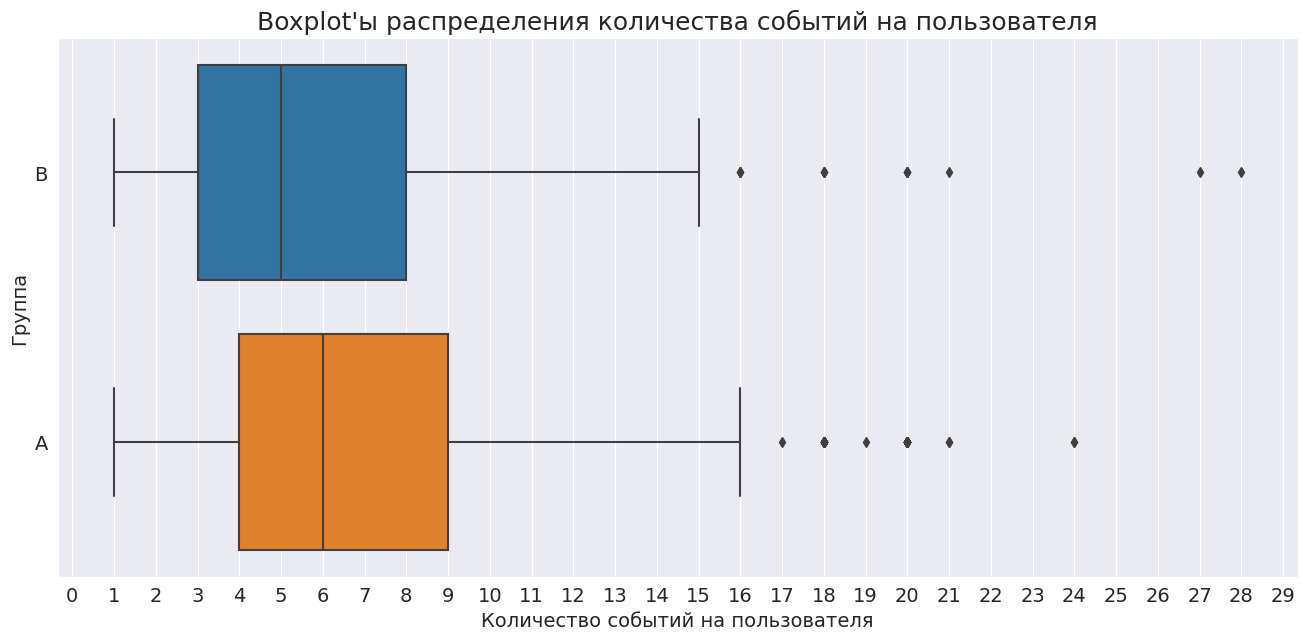

In [ ]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(16,7))
ax = sns.boxplot(data3.pivot_table(index=['user_id','group'],values='users_count',aggfunc='count').reset_index(),
            x='users_count',y='group')

ax.set_title("Boxplot'ы распределения количества событий на пользователя",fontsize=18)
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
ax.set_ylabel('Группа',fontsize=14)
ax.set_xlabel('Количество событий на пользователя',fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

In [ ]:
table_name('Таблица распределения и статистик количества событий на пользователя')
round(users_group_count.describe(),2).T

____________________________________________________________________
Таблица распределения и статистик количества событий на пользователя:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,2747.0,7.03,3.87,1.0,4.0,6.0,9.0,24.0
B,928.0,5.81,3.48,1.0,3.0,5.0,8.0,28.0


Text(0.5, 0, 'Количество событий на пользователя')

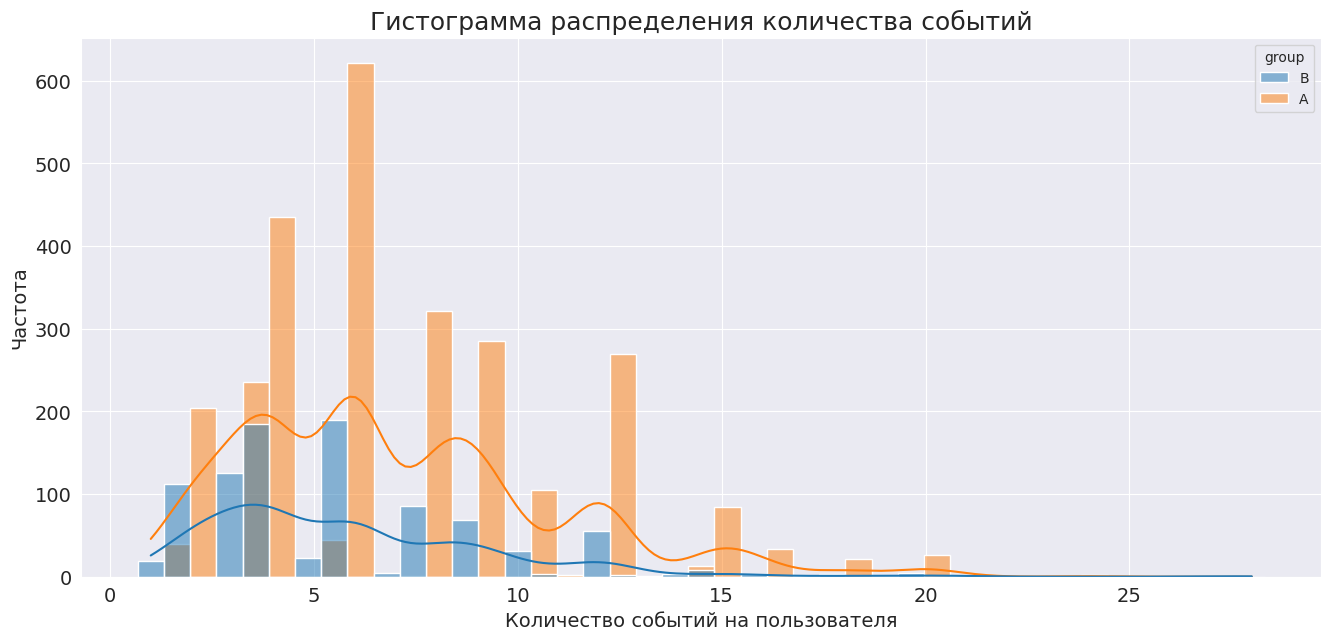

In [ ]:

sns.set_style('darkgrid')
fig = plt.figure(figsize=(16,7))
ax=sns.histplot(data3.pivot_table(index=['user_id','group'],values='users_count',aggfunc='count').reset_index(),
                x='users_count',hue='group',kde=True, multiple="dodge",shrink=2)
ax.set_title("Гистограмма распределения количества событий",fontsize=18)

ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
ax.set_ylabel('Частота',fontsize=14)
ax.set_xlabel('Количество событий на пользователя',fontsize=14)

In [ ]:
table_name('Количество событий на 1 человека в группах')
count_events_on_person=pd.DataFrame({'A':round(data3.query('group=="A"')['user_id'].count()/data3.query('group=="A"')['user_id'].nunique(),2),
              'B':round(data3.query('group=="B"')['user_id'].count()/data3.query('group=="B"')['user_id'].nunique(),2)},
             index=['count_events_on_person'])
count_events_on_person['abs_diff']=round(count_events_on_person.loc['count_events_on_person','A']-
                                    count_events_on_person.loc['count_events_on_person','B'],2)
count_events_on_person['rel_diff_%']=round((count_events_on_person.loc['count_events_on_person','A']/
                                    count_events_on_person.loc['count_events_on_person','B']-1)*100)
count_events_on_person

__________________________________________
Количество событий на 1 человека в группах:
- - - - - - - - - - - - - - - - - - - - - 


,A,B,abs_diff,rel_diff_%
count_events_on_person,7.03,5.81,1.22,21


**Вывод:** По графикам можно сделать вывод, что оба распределения схожи, однако количество пользователей в группе А больше, и в среднем в группе A совершают на 1 действие больше, чем в группе B - 7 против 5,8.
___

#### 4.2) Проанализируем как число событий в выборках распределено по дням:

In [ ]:
pd.set_option('display.max_rows', 10)
data2=data.copy()
data2['event_dt']=data2['event_dt'].dt.date
destribution_date=data2.pivot_table(index=['event_dt','group'],values='user_id',aggfunc='count')
destribution_date

user_id
event_dt   group         
2020-12-07 A          331
           B          378
2020-12-08 A          341
           B          252
2020-12-09 A          385
...                   ...
2020-12-28 A          503
           B          100
2020-12-29 A          431
           B           77
2020-12-30 B            4

[47 rows x 1 columns]

In [ ]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)
destribution_date_group=data.pivot_table(index='event_day_of_dec',columns='group',values='user_id',aggfunc='count')
destribution_date_group=destribution_date_group.fillna(0)
destribution_date_group=destribution_date_group.astype('int')
table_name('Таблица рспределения числа событий по группам и дням')
destribution_date_group.T.astype('int')

____________________________________________________
Таблица рспределения числа событий по группам и дням:
- - - - - - - - - - - - - - - - - - - - - - - - - - 


event_day_of_dec,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
group,,,,,,,,,,,,,,,,,,,,,,,,
A,331,341,385,350,374,355,328,1083,1084,1069,1252,1312,1506,1528,2011,1311,1005,888,677,608,572,503,431,0
B,378,252,361,263,168,203,176,272,232,385,296,272,304,320,430,195,196,154,112,125,119,100,77,4


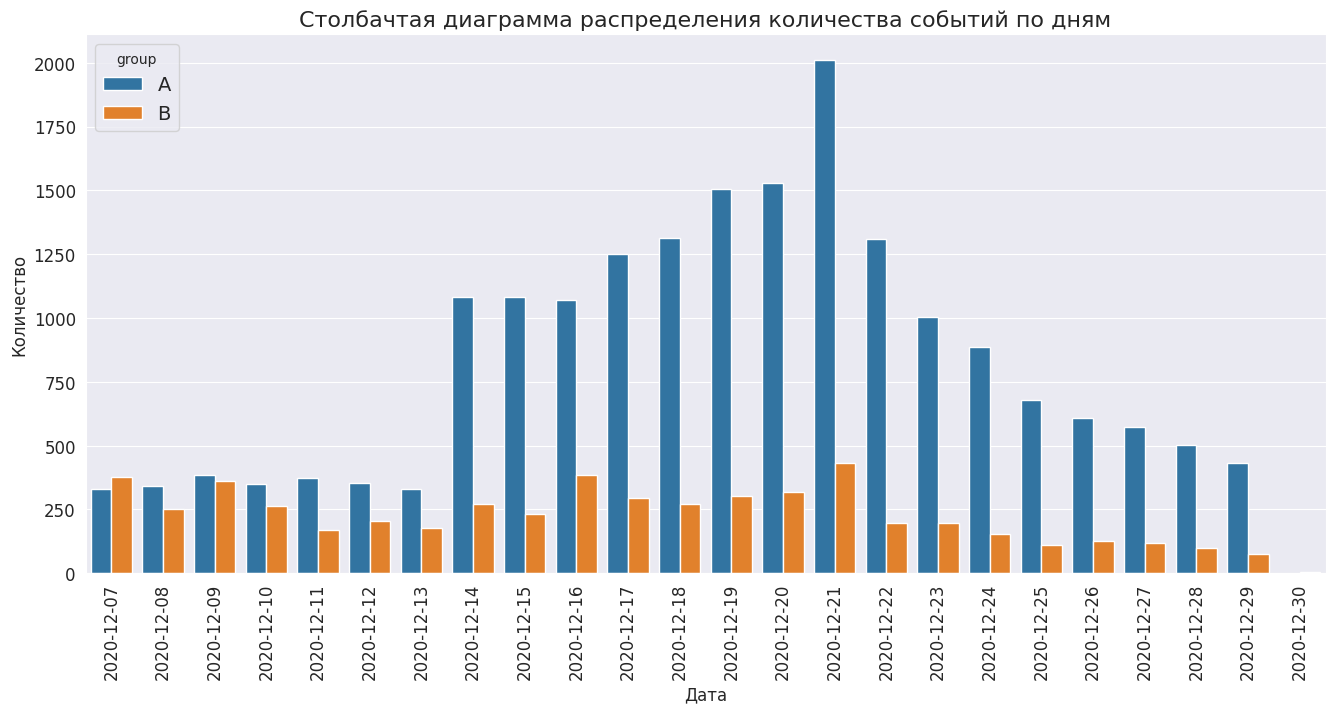

In [ ]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(16,7))
ax = sns.barplot(destribution_date.reset_index(),x='event_dt',y='user_id',hue='group')

ax.set_title("Столбачтая диаграмма распределения количества событий по дням",fontsize=16)
ax.tick_params(axis='x', labelrotation=90,labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.legend(title='group',fontsize=14)
ax.set_ylabel('Количество',fontsize=12)
ax.set_xlabel('Дата',fontsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))


<Figure size 1500x1500 with 0 Axes>

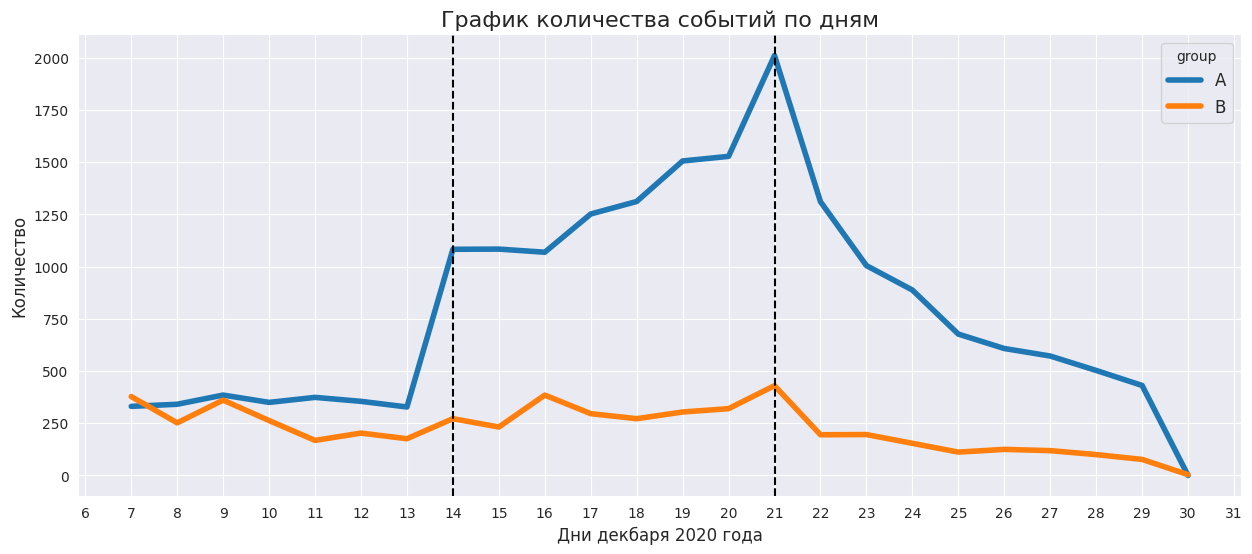

In [ ]:
fig = plt.figure(figsize=(15,15))
ax=destribution_date_group.plot(figsize=(15,6),grid=True,linewidth=4)
ax.set_title("График количества событий по дням",fontsize=16)
ax.legend(title='group',fontsize=12)
ax.set_ylabel('Количество',fontsize=12)
ax.set_xlabel('Дни декбаря 2020 года',fontsize=12)
ax.axvline(x=14,linestyle='--',color='black')
ax.axvline(x=21,linestyle='--',color='black')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

**Вывод:** В промежутке с 14 по 21 декабря не должно быть искуственных возрастаний и убываний  количества клиентов в день, так как хотя бы недельный лайфтам у них там сохраняется. До действует рост набора за каждый день клиентов. После 21 мы наоборот не набираем клиентов и график не на нуле только благодоря ранее привлеченым клиентам.

<Figure size 1500x1500 with 0 Axes>

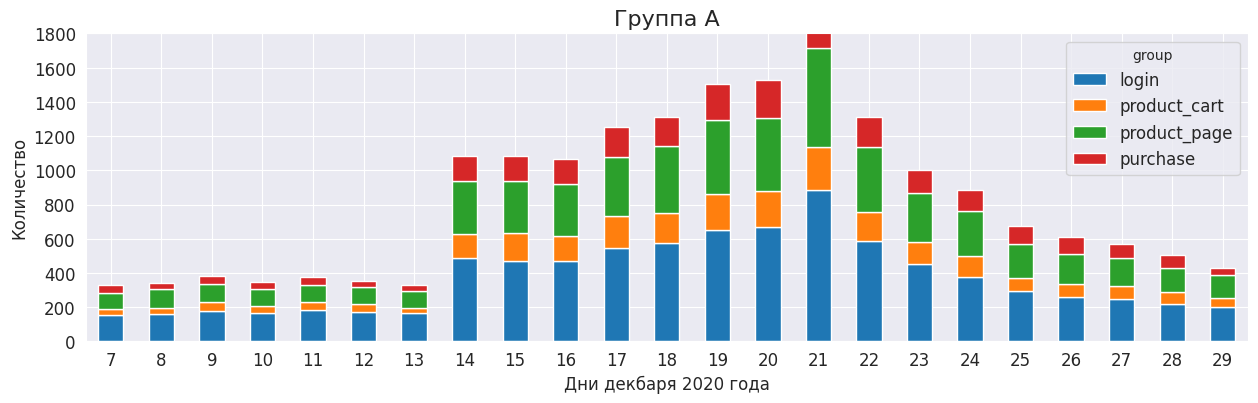

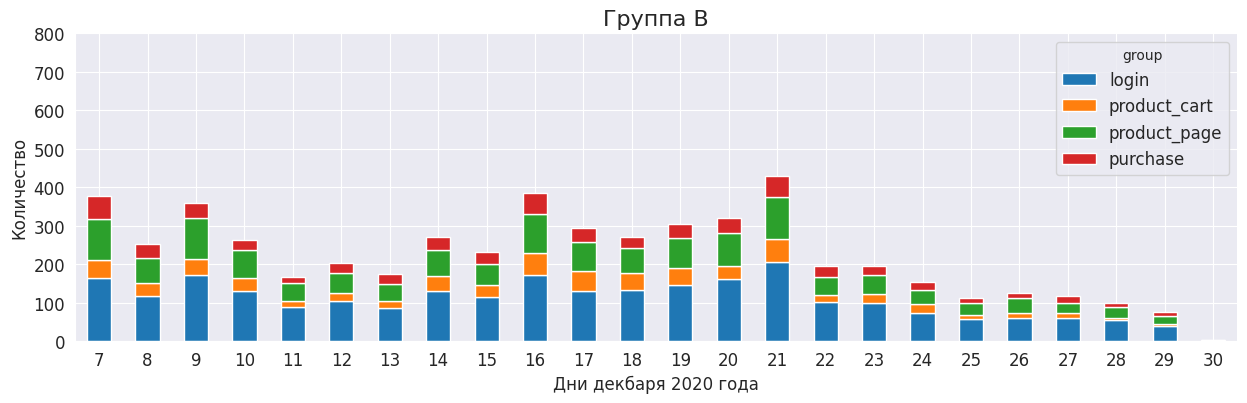

In [ ]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(15,15))
ax = data.query('group=="A"').pivot_table(index='event_day_of_dec', values='user_id', columns='event_name', aggfunc='count').plot.bar(stacked=True,figsize=(15,4),grid=True,ylim=(0,1800))
ax.set_title("Группа A",fontsize=16)
ax.legend(title='group',fontsize=12)
ax.set_ylabel('Количество',fontsize=12)
ax.set_xlabel('Дни декбаря 2020 года',fontsize=12)
ax.tick_params(axis='x', labelrotation=0,labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax = data.query('group=="B"').pivot_table(index='event_day_of_dec', values='user_id', columns='event_name', aggfunc='count').plot.bar(stacked=True,figsize=(15,4),grid=True,ylim=(0,800))
ax.set_title("Группа B",fontsize=16)
ax.legend(title='group',fontsize=12)
ax.set_ylabel('Количество',fontsize=12)
ax.set_xlabel('Дни декбаря 2020 года',fontsize=12)
ax.tick_params(axis='x', labelrotation=0,labelsize=12)
ax.tick_params(axis='y',labelsize=12)
sns.despine()

**Вывод:** На графиках видно, что пользователи разных групп ведут себя по-разному, в среднем кол-во событий возрастает до 21 декабря. У группы В до 13 декабря идет снижение. После 21 декабря в обоих случаях идет равномерный спад. За период с 25 по 30.12.2020 сильных изменений и различных всплесков не выявлено, данные можно оставить для теста, Промо не оказывает влияния на пользователей (кол-во событий равномерно снижается).

#### Рассмотрим как меняется конверсия в воронке в выборках на разных этапах:

In [ ]:
pd.set_option('display.max_rows', 10)
data_event_count

group,A,B,conv_A,conv_B,diff_conv
event_name,,,,,
login,2747,927,100.00,100.00,0.00
product_cart,824,255,30.00,27.51,-8.30
product_page,1780,523,64.80,56.42,-12.93
purchase,872,256,31.74,27.62,-12.98


In [ ]:
fig=go.Figure(go.Funnel(
    name = 'Группа A',
    orientation = "h",
    y = data_event_count.loc[['login', 'product_page', 'product_cart','purchase']].reset_index()['event_name'],
    x = data_event_count.loc[['login', 'product_page', 'product_cart','purchase']].reset_index()['A'],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(
    orientation = "h",
    name = 'Группа B',
    y = data_event_count.loc[['login', 'product_page', 'product_cart','purchase']].reset_index()['event_name'],
    x = data_event_count.loc[['login', 'product_page', 'product_cart','purchase']].reset_index()['B'],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.update_layout(
    title='Продуктовая воронка (конверсия)',
    font_family="Courier New",
    title_font_color="red",
    legend_title_font_color="green"
)

**Вывод:** Количество действий product_cart (Просмотр корзины) меньше, чем purchase (Покупка), что странно. Такое возможно, если пользователь оформляет заказ не через корзину, а напрямую, например по кнопке "заказать в 1 клик". Тем не менее, для воронки мы будем использовать воронку определенную выше.

___
**ВЫВОД:**

**Графики распределения событий на пользователя схожи однако у группы А в среднем больше чем у группы В на 1 событие (или на 21%) - 5.81 у группы В против 7 у группы А.**

**Распределение количества событий по дням таково:**

* Группа А стабильно выше группы В по количеству событий;
* С 14 по 21 декабря так называемые границы нормальности - когда тест наиболее объективно показывает распределение по дням. До этого рост вызванный началом. После спад после окончания набора

**Конверсия такова:**

             А:      В:
login - - - - - - 100.00 - 100.00;   
product_page  64.80 - -56.42  
product_cart - 30.00 - -27.51  
purchase - - - 31.74 - - 27.6
___

### 5) Оценим результаты A/B-тестирования:

**Проверим конверсию по всем трем этапам:**

Для проведения теста будем использовать - гипотезы о равенстве долей. Сформулируем нулевую и альтернативную гипотезу:

* Нулевая гипотеза: доли не имеют статистических различий.
* Альтернативная гипотеза: доли имеют статистические различия.



In [ ]:
table_name('Выведем таблицу конверсии')
data_event_count

_________________________
Выведем таблицу конверсии:
- - - - - - - - - - - - 


group,A,B,conv_A,conv_B,diff_conv
event_name,,,,,
login,2747,927,100.00,100.00,0.00
product_cart,824,255,30.00,27.51,-8.30
product_page,1780,523,64.80,56.42,-12.93
purchase,872,256,31.74,27.62,-12.98


По ней видно что ни одна метрика не улучшилась. Но ухудшилась в среднем на более 10%.

Для проведения тестов создадим функцию:

In [ ]:
def event_z_value(alpha,chosen_event,first_group,second_group,login_or_registration):
    only_event = np.array([data_event_count.loc[chosen_event,first_group],data_event_count.loc[chosen_event,second_group]])
    if login_or_registration=='login':
        leads  = np.array([data_event_count.loc['login',first_group], data_event_count.loc['login',second_group]])
    elif login_or_registration=='registration':
        leads  = np.array([share_group.loc[first_group,'user_id'], share_group.loc[second_group,'user_id']])
    p1=only_event[0]/leads[0]
    p2=only_event[1]/leads[1]
    p_combined=only_event.sum()/leads.sum()
    difference=p1-p2
    data_event_count.loc[chosen_event,str(first_group)+'_rel']=p1
    data_event_count.loc[chosen_event,str(second_group)+'_rel']=p2
    z_value = difference/math.sqrt(p_combined*(1-p_combined)*(1/leads[0]+1/leads[1]))
    distr = st.norm(0, 1)

    p_value = (1-distr.cdf(abs(z_value)))*2
    data_event_count.loc[chosen_event,'p_value']=p_value

    #print('p-значение: ', p_value)
    if p_value<alpha:
        data_event_count.loc[chosen_event,'hypotises_adoption']='Отвергаем нулевую гипотезу'
        data_event_count.loc[chosen_event,'hypotises_decision']='Между долями есть значимая разница'
    #    return print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        data_event_count.loc[chosen_event,'hypotises_adoption']='Не получилось отвергнуть нулевую гипотезу'
        data_event_count.loc[chosen_event,'hypotises_decision']='Нет оснований считать доли разными'
    #    return print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    return data_event_count

In [ ]:
for x in data_event_count.index:
    event_z_value(alpha=0.05, chosen_event=x,first_group='A',second_group='B',login_or_registration='login')
table_name('Таблица с выводами о статзначимой разнице долей этапов воронки z-критерием /login/')
data_event_count

__________________________________________________________________________________
Таблица с выводами о статзначимой разнице долей этапов воронки z-критерием /login/:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


group,A,B,conv_A,conv_B,diff_conv,A_rel,B_rel,p_value,hypotises_adoption,hypotises_decision
event_name,,,,,,,,,,
login,2747,927,100.00,100.00,0.00,1.000000,1.000000,NaN,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными
product_cart,824,255,30.00,27.51,-8.30,0.299964,0.275081,0.150342,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными
product_page,1780,523,64.80,56.42,-12.93,0.647980,0.564186,0.000005,Отвергаем нулевую гипотезу,Между долями есть значимая разница
purchase,872,256,31.74,27.62,-12.98,0.317437,0.276160,0.018475,Отвергаем нулевую гипотезу,Между долями есть значимая разница


**Вывод:** В результате данных проверок, статистически значимая разница конверсии от ЛОГИНОВ в группах А и В появилась на втором и третьем шаге воронки (login -> product_page и login -> purchase), на первом шаге (login -> product_cart) найти статистически значимую разницу не удалось.

In [ ]:
for x in data_event_count.index:
    event_z_value(alpha=0.05, chosen_event=x,first_group='A',second_group='B',login_or_registration='registration')
table_name('Таблица с выводами о статзначимой разнице долей этапов воронки z-критерием /registration/')
data_event_count

_________________________________________________________________________________________
Таблица с выводами о статзначимой разнице долей этапов воронки z-критерием /registration/:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


group,A,B,conv_A,conv_B,diff_conv,A_rel,B_rel,p_value,hypotises_adoption,hypotises_decision
event_name,,,,,,,,,,
login,2747,927,100.00,100.00,0.00,0.718358,0.322211,0.0,Отвергаем нулевую гипотезу,Между долями есть значимая разница
product_cart,824,255,30.00,27.51,-8.30,0.215481,0.088634,0.0,Отвергаем нулевую гипотезу,Между долями есть значимая разница
product_page,1780,523,64.80,56.42,-12.93,0.465481,0.181787,0.0,Отвергаем нулевую гипотезу,Между долями есть значимая разница
purchase,872,256,31.74,27.62,-12.98,0.228033,0.088982,0.0,Отвергаем нулевую гипотезу,Между долями есть значимая разница


**Вывод:** В результате данных проверок, статистически значимая разница конверсии от РЕГИСТРАЦИИ в группах А и В возникла уже на этапе логина и продолжилась до конца. То есть нужно отвергнуть все нулевые гипотезы и признать что между долями есть статзначимая разница.

**ВЫВОД: Если обобщить то можно утверждать что у группы В нет преимуществ по сравнению с группой А. Можно завершить проверку теста.**

___
___

### ВЫВОД:

**В результате исследования было выявлено следующее:**

- Есть пользователи в двух разных тестах (9.61 %);
- Внутри групп пользователи не пересекаются;
- Удалены пользователи, зарегистрировавшиеся после 21 декабря 2020;
- Удалены события, которые были далее 14 дней с момента регистрации;
- Отсутствует активность пользователей после 30.12.2020;
- Существуют маркетинговые события в период теста, однако как  выяснилось неравномерных всплесков это не дает;
- Аудитория теста состоит из 15 % новых пользователей из региона EU;
- В среднем на одного пользователя из группа B - 7, в группе В - 5,8;
- В период с 14.12.2020 количество событий начинает возрастать, после 21.12.2020 резко падает, что обусловленно ;
- Конверсия группы В на всех этапах ниже группы А;

**Стат. тест также подтвердил, что на втором и третьем шаге воронки между долями есть значимая разница, на первом шаге найти статистически значимую разницу не удалось. Конверсия, вместо ожидаемого роста на 10%, упала более чем на 10%.**

#### Общий вывод:

**В процессе исследования оценили корректность проведения А/В теста, провели статистический тест для оценки равенства долей. Сделаем вывод о том, что А/В-тест можно считать состоявшимся. Но вот ожидаемого эффекта (прироста конверсий) не случилось.  По итогам исследования не стоить рекомендовать внедрение новой рекомендательной системы на всех пользователей сайта. Предлагается завершить тест, провести более корректное планирование и затем заново провести тест.**